# Gaussian Mixture VAE

Trained with ELBO that marginalizes the discrete latent variable.

Translates this tensorflow 1.X codebase https://github.com/Domceng/gmvae to PyTorch.

## Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as d

from scipy.optimize import linear_sum_assignment

from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
OneHotCat = d.OneHotCategorical

Ind = d.Independent
Normal = d.Normal

Bern = d.Bernoulli

## Generative model

### Module for p(y)

In [3]:
class p_y_class(nn.Module):
    
    def __init__(self, y_dim):
        super().__init__()
        self.y_dim = y_dim
        self.logits = torch.ones(y_dim)
        
    def forward(self):
        return OneHotCat(logits=self.logits)

### Module for p(z|y)

In [4]:
class p_z_class(nn.Module):
    
    def __init__(self, y_dim, z_dim):
        super().__init__()
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.mus = nn.Linear(y_dim, z_dim)
        self.sigmas = nn.Sequential(
            nn.Linear(y_dim, z_dim),
            nn.Softplus()
        )
        
    def forward(self, ys):
        return Ind(Normal(self.mus(ys), self.sigmas(ys)), 1)

### Module for p(x|z)

In [5]:
class p_x_class(nn.Module):

    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.probs = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, x_dim),
            nn.Sigmoid()
        )

    def forward(self, zs):
        return Ind(Bern(self.probs(zs)), 1)

## Approximate posterior

### Module for q(y|x)

In [6]:
class q_y_class(nn.Module):
    
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.layers = nn.Sequential(
            nn.Linear(x_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, y_dim)
        )
        
    def forward(self, xs):
        return OneHotCat(logits=self.layers(xs))

### Module for q(z|x, y)

In [7]:
class q_z_class(nn.Module):

    def __init__(self, x_dim, y_dim, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.shared = nn.Sequential(
            nn.Linear(x_dim + y_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
        )
        self.mus = nn.Linear(512, z_dim)
        self.sigmas = nn.Sequential(
            nn.Linear(512, z_dim),
            nn.Softplus()
        )

    def forward(self, xs, ys):
        temp = self.shared(torch.cat([xs, ys], dim=1))
        return Ind(Normal(self.mus(temp), self.sigmas(temp)), 1)

## AEVB

In [8]:
import torch.nn.functional as F

In [9]:
class AEVB(nn.Module):
    
    def __init__(self, x_dim, y_dim, z_dim, lr=1e-3):
        
        super().__init__()
        
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        
        # generative model
        
        self.p_y = p_y_class(y_dim)
        self.p_z = p_z_class(y_dim, z_dim)
        self.p_x = p_x_class(x_dim, z_dim)

        # approximate posterior
        
        self.q_y = q_y_class(x_dim, y_dim)
        self.q_z = q_z_class(x_dim, y_dim, z_dim)
        
        # optimizers
        
        self.opt = optim.Adam(self.parameters())
            
    def step(self, xs, train):

        q_y = self.q_y(xs)                                # approximate posterior over ys
        cond_ent = - (q_y.probs * q_y.logits).sum(dim=1)  # conditional entropy
        cond_ent_mean = cond_ent.mean()                   # averaged over examples
        
        # logits is equivalent to log_prob for a torch distribution
        
        # ========== code below vectorizes marginalization =========

        bs = xs.size(0)
    
        ys = torch.eye(self.y_dim)[torch.tensor(range(self.y_dim)).repeat_interleave(bs)]  # for marginalization
        xs = xs.repeat(self.y_dim, 1)  # for marginalization
        
        post_over_zs = self.q_z(xs, ys)
        zs = post_over_zs.rsample()
        
        other = self.p_x(zs).log_prob(xs) - d.kl.kl_divergence(post_over_zs, self.p_z(ys))
        other = other.reshape(self.y_dim, bs).T  # reshape(bs, self.y_dim) gives incorrect results
        other = (q_y.probs * other).sum(dim=1)  # element-wise multiplication, then compute expected value under q_y
        
        # ========== code above vectorizes marginalization =========
        
        estimated_elbo = other.mean() + cond_ent_mean  # not including constant term
        loss = - estimated_elbo
        
        if train:
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        
        return float(estimated_elbo), float(cond_ent_mean)
    
    def predict_cluster(self, xs):
        with torch.no_grad():
            return self.q_y(xs).mean.argmax(dim=1)
    
    def generate(self, n, mode):
        with torch.no_grad():
            ys = self.p_y().sample((n, ))
            zs = self.p_z(ys).sample()
            if mode == "mean":
                xs = self.p_x(zs).mean
            elif mode == "sample":
                xs = self.p_x(zs).sample()
            elif mode == "param":
                xs = self.p_x.probs(zs)
            return xs
    
    def generate_from_cluster(self, n, cluster_index, mode):
        with torch.no_grad():
            ys = torch.eye(self.y_dim)[cluster_index].repeat(n, 1)
            zs = self.p_z(ys).sample()
            if mode == "mean":
                xs = self.p_x(zs).mean
            elif mode == "sample":
                xs = self.p_x(zs).sample()
            elif mode == "param":
                xs = self.p_x.probs(zs)
            return xs

In [10]:
aevb = AEVB(x_dim=28*28, y_dim=10, z_dim=64)

In [11]:
data = torch.ones(5, 28*28).clip(0, 1)

In [12]:
aevb.step(data, train=True)

(-549.3275756835938, 2.2952752113342285)

## Data

In [13]:
import numpy as np
from keras.datasets.mnist import load_data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [14]:
(x_train, y_train), (x_test, y_test) = load_data()

# x_train = x_train[np.where((y_train == 0) | (y_train == 2) | (y_train == 4))]
# y_train = y_train[np.where((y_train == 0) | (y_train == 2) | (y_train == 4))]

# x_test = x_test[np.where((y_test == 0) | (y_test == 2) | (y_test == 4))]
# y_test = y_test[np.where((y_test == 0) | (y_test == 2) | (y_test == 4))]

x_train = x_train + np.random.uniform(low=0, high=1, size=x_train.shape)
x_train = x_train / 256
x_train = x_train.reshape(-1, 28*28)

x_test = x_test + np.random.uniform(low=0, high=1, size=x_test.shape)
x_test = x_test / 256
x_test = x_test.reshape(-1, 28*28)

x_train[x_train > 0.5] = 1 
x_train[x_train <= 0.5] = 0

x_test[x_test > 0.5] = 1 
x_test[x_test <= 0.5] = 0

train_ds = TensorDataset(torch.from_numpy(x_train).float())
train_dl = DataLoader(train_ds, batch_size=100)

test_ds = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).long())
test_dl = DataLoader(test_ds, batch_size=1000, shuffle=False)

x_test_torch = torch.from_numpy(x_test).float()

## Training

In [15]:
def cluster_acc(Y_pred, Y):
    Y_pred, Y = np.array(Y_pred), np.array(Y)
    assert Y_pred.size == Y.size
    D = max(Y_pred.max(), Y.max())+1
    w = np.zeros((D,D), dtype=np.int64)
    for i in range(Y_pred.size):
        w[Y_pred[i], Y[i]] += 1
    row, col = linear_sum_assignment(w.max()-w)
    return sum([w[row[i],col[i]] for i in range(row.shape[0])]) * 1.0/Y_pred.size

In [16]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

Please re-run this cell below if you want to re-train the model. Note that training seems to be highly dependent on initial condition.

In [17]:
# aevb = AEVB(x_dim=28*28, y_dim=10, z_dim=64)
# aevb.apply(init_weights)

# test_acc = cluster_acc(aevb.predict_cluster(x_test_torch).numpy(), y_test)
# print(test_acc)

# for epoch in range(100):
    
#     print(epoch)
    
#     for (xb, ) in tqdm(train_dl):
#         aevb.step(xb, train=True)
    
#     test_elbo, test_cond_ent = aevb.step(x_test_torch, train=False)
#     test_acc = cluster_acc(aevb.predict_cluster(x_test_torch).numpy(), y_test)
    
#     print(test_cond_ent, test_elbo, test_acc)

# torch.save(aevb.state_dict(), "gmvae.pth")

In [18]:
aevb = AEVB(x_dim=28*28, y_dim=10, z_dim=64)
aevb.load_state_dict(torch.load("gmvae.pth", map_location=torch.device("cpu")))

<All keys matched successfully>

## Clustering acc

In [19]:
cluster_acc(aevb.predict_cluster(x_test_torch).numpy(), y_test)

0.8351

## Prop assigned to each class

Caution: Indices do not correspond directly to digit classes.

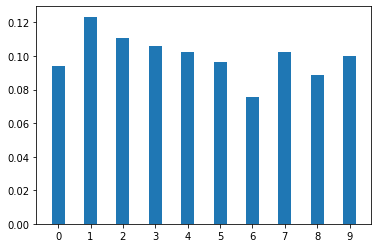

In [20]:
preds = aevb.predict_cluster(x_test_torch).numpy()
props = pd.value_counts(preds) / len(preds)
plt.bar(props.index.tolist(), props, width=0.4)
plt.xticks(np.arange(10))
plt.show()

## Generation

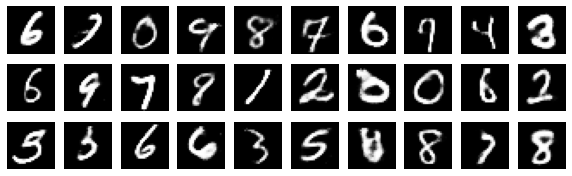

In [21]:
torch.manual_seed(10)
gens = aevb.generate(n=30, mode="mean").detach()
plt.figure(figsize=(10, 3))
for i in range(1, 31):
    plt.subplot(3, 10, i)
    plt.imshow(gens[i-1].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.savefig("mnist_gens_param.pdf", bbox_inches='tight',pad_inches = 0)

## Generation per category

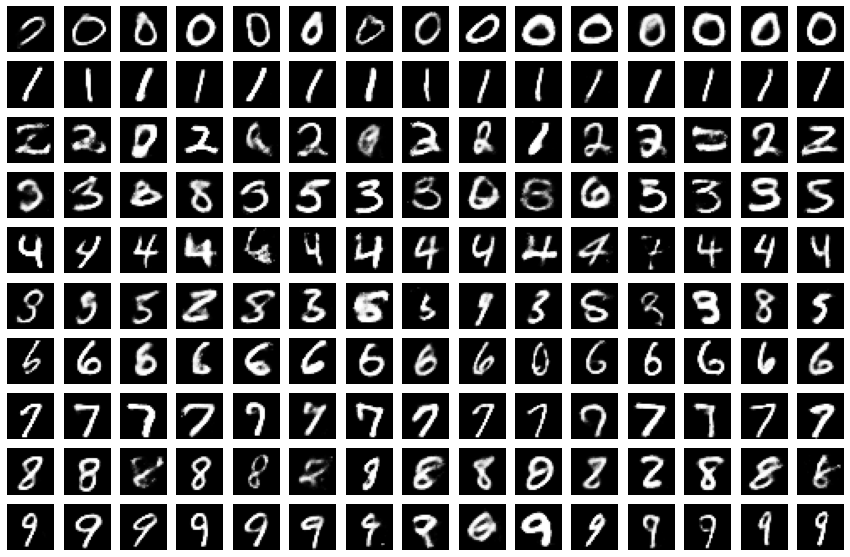

In [23]:
torch.manual_seed(12)
plt.figure(figsize=(15, 10))
for row_index, cluster_index in enumerate([7, 2, 4, 1, 3, 8, 6, 0, 9, 5]):
    gens = aevb.generate_from_cluster(n=15, cluster_index=cluster_index, mode="mean")
    for col_index in range(15):
        plt.subplot(10, 15, row_index * 15 + col_index + 1)
        plt.imshow(gens[col_index].reshape(28, 28), cmap="gray")
        plt.axis('off')
plt.savefig("mnist_gens_conditional_param.pdf", bbox_inches='tight',pad_inches = 0)
plt.savefig("mnist_gens_conditional_param.png", bbox_inches='tight',pad_inches = 0, dpi=100)